In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [14]:
df = pd.read_csv(r"C:\Users\dubey\OneDrive\Desktop\Coding\ML_Lab\Lab7\drug_200.csv")

y = LabelEncoder().fit_transform(df["Drug"])
X = df.drop(columns=["Drug"])
print(X)
print(y)
# One-hot encode only categorical features
X = pd.get_dummies(X, drop_first=True)

# Standardize
X = (X - X.mean()) / X.std()
X = X.values

     Age Sex      BP Cholesterol  Na_to_K
0     23   F    HIGH        HIGH   25.355
1     47   M     LOW        HIGH   13.093
2     47   M     LOW        HIGH   10.114
3     28   F  NORMAL        HIGH    7.798
4     61   F     LOW        HIGH   18.043
..   ...  ..     ...         ...      ...
195   56   F     LOW        HIGH   11.567
196   16   M     LOW        HIGH   12.006
197   52   M  NORMAL        HIGH    9.894
198   23   M  NORMAL      NORMAL   14.020
199   40   F     LOW      NORMAL   11.349

[200 rows x 5 columns]
[4 2 2 3 4 3 4 2 4 4 2 4 4 4 3 4 3 0 2 4 4 4 4 4 4 4 4 3 4 4 3 1 3 4 3 3 0
 3 3 3 4 1 4 3 3 3 0 2 4 4 4 3 4 4 1 2 1 4 3 4 4 0 4 3 1 4 0 3 4 4 1 4 3 4
 4 4 0 4 0 3 1 3 2 0 2 1 3 4 4 4 4 4 4 4 4 3 4 4 4 4 0 0 2 3 4 3 3 4 1 4 0
 3 3 3 3 4 3 3 0 4 4 4 4 4 1 4 4 3 4 3 4 4 3 4 4 3 1 0 1 3 0 4 1 4 0 3 3 0
 3 2 0 1 3 3 4 2 0 4 2 3 3 1 3 4 4 4 4 3 4 0 3 3 4 4 0 4 0 4 4 4 4 3 3 4 4
 4 1 0 4 4 4 0 4 2 4 2 2 3 3 3]


In [15]:
X

array([[-1.28835799,  1.28330178, -1.03822766, -0.68427721, -0.64524997,
        -0.96800766],
       [ 0.1622914 , -0.41410623,  0.95836399,  1.45408906, -0.64524997,
        -0.96800766],
       [ 0.1622914 , -0.82648419,  0.95836399,  1.45408906, -0.64524997,
        -0.96800766],
       ...,
       [ 0.46451002, -0.85693841,  0.95836399, -0.68427721,  1.54203805,
        -0.96800766],
       [-1.28835799, -0.28578318,  0.95836399, -0.68427721,  1.54203805,
         1.02788443],
       [-0.26081467, -0.65552521, -1.03822766,  1.45408906, -0.64524997,
         1.02788443]])

In [16]:
def kfold_split(X, y, k=5, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(y))
    fold_size = len(y) // k
    folds = []
    for i in range(k):
        test_idx = indices[i * fold_size : (i + 1) * fold_size]
        train_idx = np.setdiff1d(indices, test_idx)
        folds.append((train_idx, test_idx))
    return folds


In [17]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred):
    classes = np.unique(y_true)
    precisions, recalls, f1s = [], [], []
    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [18]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.1, epochs=1000, reg=None, lam=0.01, alpha=0.5):
        self.lr = lr
        self.epochs = epochs
        self.reg = reg  # None, 'l1', 'l2', 'elasticnet'
        self.lam = lam
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        Y = np.eye(n_classes)[y]

        self.W = np.zeros((n_features, n_classes))
        self.b = np.zeros(n_classes)

        for _ in range(self.epochs):
            logits = X @ self.W + self.b
            probs = softmax(logits)
            error = probs - Y
            grad_W = X.T @ error / n_samples
            grad_b = np.mean(error, axis=0)

            # Regularization
            if self.reg == "l2":
                grad_W += self.lam * self.W
            elif self.reg == "l1":
                grad_W += self.lam * np.sign(self.W)
            elif self.reg == "elasticnet":
                grad_W += self.lam * (self.alpha * np.sign(self.W) + (1 - self.alpha) * self.W)

            # Gradient descent update
            self.W -= self.lr * grad_W
            self.b -= self.lr * grad_b

    def predict(self, X):
        probs = softmax(X @ self.W + self.b)
        return np.argmax(probs, axis=1)


In [19]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            dists = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            idx = np.argsort(dists)[:self.k]
            votes = Counter(self.y_train[idx]).most_common(1)[0][0]
            y_pred.append(votes)
        return np.array(y_pred)


In [20]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall_f1(y_true, y_pred):
    classes = np.unique(y_true)
    precisions, recalls, f1s = [], [], []
    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [21]:
def cross_validate(model_class, X, y, **kwargs):
    folds = kfold_split(X, y, k=5)
    accs, precs, recs, f1s = [], [], [], []

    for train_idx, test_idx in folds:
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = model_class(**kwargs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accs.append(accuracy(y_test, y_pred))
        p, r, f = precision_recall_f1(y_test, y_pred)
        precs.append(p)
        recs.append(r)
        f1s.append(f)

    return {
        "Accuracy": np.mean(accs),
        "Precision": np.mean(precs),
        "Recall": np.mean(recs),
        "F1": np.mean(f1s),
    }



5-Fold Cross Validation Results:
                     Accuracy  Precision    Recall        F1
Logistic-No Reg         0.950   0.936577  0.961844  0.941969
Logistic-L2             0.805   0.820056  0.700570  0.709188
Logistic-L1             0.665   0.276532  0.379519  0.315911
Logistic-ElasticNet     0.680   0.482356  0.487802  0.453926
KNN-k=1                 0.895   0.871286  0.928733  0.880698
KNN-k=3                 0.830   0.841937  0.868683  0.840656
KNN-k=5                 0.780   0.762178  0.819271  0.774097


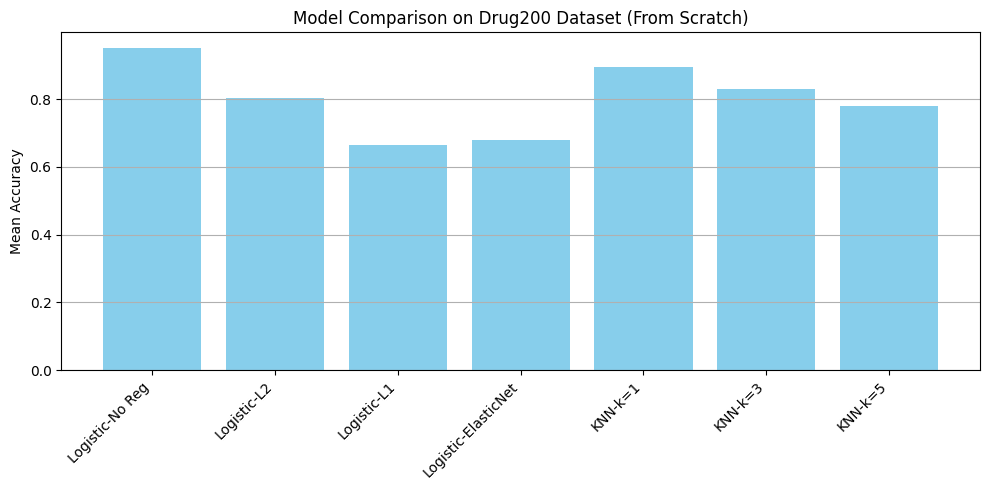

In [22]:
results = {}

for name, reg in [("No Reg", None), ("L2", "l2"), ("L1", "l1"), ("ElasticNet", "elasticnet")]:
    res = cross_validate(LogisticRegressionScratch, X, y, reg=reg, lam=0.1, alpha=0.5, epochs=4000, lr=0.1)
    results[f"Logistic-{name}"] = res

for k in [1, 3, 5]:
    res = cross_validate(KNN, X, y, k=k)
    results[f"KNN-k={k}"] = res

results_df = pd.DataFrame(results).T
print("\n5-Fold Cross Validation Results:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.bar(results_df.index, results_df["Accuracy"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Accuracy")
plt.title("Model Comparison on Drug200 Dataset (From Scratch)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()
